# Integrating Product Design and Supply Chain Design

## Import Packages

In [1767]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import gurobipy as gp
from gurobipy import GRB
from gurobipy import quicksum as qsum
import pandas as pd
from pandas import DataFrame, read_csv
import random
import math
import sys

In [1768]:
def handleGurobiStatus(m : gp.Model):
    status = m.status
    if status == GRB.Status.INFEASIBLE:
        print("The model is infeasible. Computing IIS.")
        m.computeIIS()
        m.write('iismodel.ilp')
        sys.exit(0)
    elif status == GRB.Status.UNBOUNDED:
        print("The model is unbounded.")
        sys.exit(0)
    elif status == GRB.Status.OPTIMAL:
        print("The model is optimal.")
    elif status == GRB.Status.INF_OR_UNBD:  
        print("The model status is infeasible or unbounded. Set DualReductions parameter to 0 and reoptimize.")
        sys.exit(0)
    else:
        print("The model status is neither infeasible nor unbounded.")
        sys.exit(0)

## Parameters

In [1769]:
# multiEchelon = True
# if multiEchelon:
#     numAssemblies = 2
#     numComponentsPerAssembly = 2
#     numComponents = numAssemblies * numComponentsPerAssembly
# else:
#     numComponents = 2

# numSuppliers = 4
# numAssemblyOptions = 2
# numPartOptionsForComponent = 2
# numSuppliersPerPart = 2

timeUB = 5

In [1770]:
numTiers = 3
numOptions = 2

np.random.seed(0)

In [1771]:
def get_descendent_parts(G: nx.DiGraph, node):
    myList = [i for i in nx.ancestors(G, node) if G.nodes[i]['tier'] == numTiers]
    if G.nodes[node]['tier'] == numTiers:
        myList.append(node)
    return myList

## BOM: Components

[(1, {'depth': 3, 'tier': 0, 'process_time': 1, 'max_service_time_out': 0, 'stage_cost': 1}), (2, {'depth': 2, 'process_time': 4, 'max_service_time_out': 100, 'stage_cost': 4, 'tier': 1}), (3, {'depth': 2, 'process_time': 4, 'max_service_time_out': 100, 'stage_cost': 2, 'tier': 1}), (4, {'depth': 1, 'process_time': 4, 'max_service_time_out': 100, 'stage_cost': 3, 'tier': 2}), (5, {'depth': 1, 'process_time': 1, 'max_service_time_out': 100, 'stage_cost': 1, 'tier': 2}), (8, {'depth': 0, 'process_time': 1, 'max_service_time_out': 100, 'stage_cost': 5, 'tier': 3}), (9, {'depth': 0, 'process_time': 3, 'max_service_time_out': 100, 'stage_cost': 2, 'tier': 3}), (10, {'depth': 0, 'process_time': 3, 'max_service_time_out': 100, 'stage_cost': 1, 'tier': 3}), (11, {'depth': 0, 'process_time': 2, 'max_service_time_out': 100, 'stage_cost': 2, 'tier': 3}), (6, {'depth': 1, 'process_time': 2, 'max_service_time_out': 100, 'stage_cost': 1, 'tier': 2}), (7, {'depth': 1, 'process_time': 2, 'max_service_

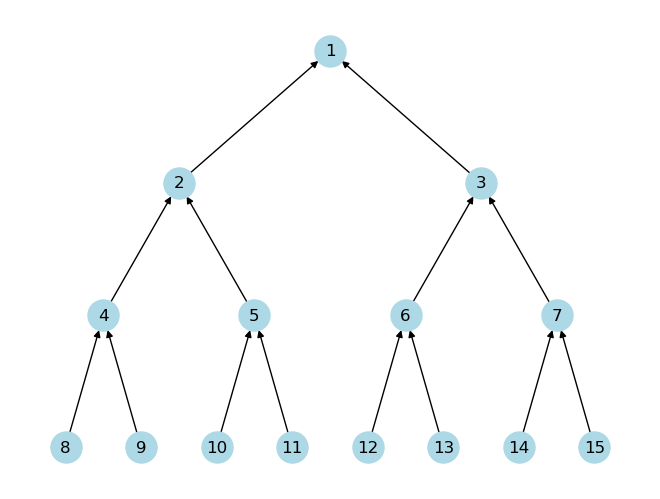

In [1772]:
def buildBOMGraph():

    def add_edges(G, node, depth, pos, x=0, y=0, dx=1):
        pos[node] = (x, y)
        G.nodes[node]['depth'] = depth
        #print(node, G.nodes[node])
        if depth > 0:
            node_left = node*2
            node_right = node*2 + 1
            G.add_edge(node_left, node)
            G.add_edge(node_right, node)
            add_edges(G, node_left, depth-1, pos, x-dx, y-1, dx/2)
            add_edges(G, node_right, depth-1, pos, x+dx, y-1, dx/2)

    G = nx.DiGraph()
    root_node = 1
    pos = {}
    G.add_node(root_node, depth = numTiers, tier = 0)
    #print(G.nodes(data=True))
    add_edges(G, root_node, numTiers, pos)
    for i in G.nodes():
        time = np.random.randint(1, timeUB)
        if i == root_node:
            maxTime = 0
        else:
            maxTime = 100
        G.nodes[i]['process_time'] = time
        G.nodes[i]['max_service_time_out'] = maxTime
        G.nodes[i]['stage_cost'] = np.random.randint(1, 6)
        G.nodes[i]['tier'] = numTiers - G.nodes[i]['depth']
    print(G.nodes(data=True))
    for i in G.nodes():
        G.nodes[i]['desc_parts'] = get_descendent_parts(G, i)
    return G, pos

bomGraph, bomGraphPos = buildBOMGraph()
nx.draw(bomGraph, bomGraphPos, with_labels=True, node_color='lightblue', node_size=500)
plt.show()

maxServiceTimeOut = nx.get_node_attributes(bomGraph, 'max_service_time_out')
processTimesDict = nx.get_node_attributes(bomGraph, 'process_time')
stageCostDict = nx.get_node_attributes(bomGraph, 'stage_cost')
maxServiceTimeOut = nx.get_node_attributes(bomGraph, 'max_service_time_out')

In [1773]:
safetyFactor = 1
sigma = 1
holdingCostRate = 0.1

In [1774]:
def getMaxReplenishmentTime(G : nx.DiGraph, n : int):
    if G.nodes[n]['tier'] == numTiers:
        return processTimesDict[n]
    else:
        return processTimesDict[n] + max([getMaxReplenishmentTime(G, i) for i in G.predecessors(n)])
    
def getMaxReplenishmentTime(G : nx.DiGraph, n : int):
    if G.nodes[n]['tier'] == numTiers:
        return processTimesDict[n]
    else:
        return processTimesDict[n] + max([getMaxReplenishmentTime(G, i) for i in G.predecessors(n)])
    
def getCumCost(G : nx.DiGraph, n : int):
    if G.nodes[n]['tier'] == numTiers:
        return stageCostDict[n]
    else:
        return stageCostDict[n] + sum([getCumCost(G, i) for i in G.predecessors(n)])

maxReplenishmentTime = {n : getMaxReplenishmentTime(bomGraph, n) for n in bomGraph.nodes()}
cumCost = {n : getCumCost(bomGraph, n) for n in bomGraph.nodes()}

df = pd.DataFrame({
    'Node': maxReplenishmentTime.keys(),
    'Process time': processTimesDict.values(),
    'Stage cost': stageCostDict.values(),
    'Cumulative cost': cumCost.values(),
    'Max time': maxServiceTimeOut.values(),
    'maxReplenishmentTime': maxReplenishmentTime.values()
})
df.to_csv('instance.csv')
df

,Node,Process time,Stage cost,Cumulative cost,Max time,maxReplenishmentTime
0,1,1,1,35,0,12
1,2,4,4,18,100,11
2,3,4,2,16,100,10
3,4,4,3,10,100,7
4,5,1,1,4,100,4
5,8,1,5,5,100,1
6,9,3,2,2,100,3
7,10,3,1,1,100,3
8,11,2,2,2,100,2
9,6,2,1,3,100,6


In [1775]:
def get_sIn_range_for_g_fn(node : int):
    maxVal = maxReplenishmentTime[node] - processTimesDict[node]
    return range(maxVal + 1)

def get_sOut_range_for_g_fn_forIn(G : nx.DiGraph, node : int, sIn : int):
    maxVal = sIn + processTimesDict[node]
    if G.nodes[node]['tier'] < numTiers:
        maxVal = min(maxVal, maxServiceTimeOut[node])
    return range(maxVal+1)

def get_sOut_range_for_g_fn_all(G : nx.DiGraph,node : int):
    vals = set()
    for sIn in get_sIn_range_for_g_fn(node):
        vals = vals.union(set(get_sOut_range_for_g_fn_forIn(G, node, sIn)))
    return vals

def get_possible_sin_for_sout_at_pred(node : int, sOut_at_pred : int, maxSOut_at_pred : int):
    if sOut_at_pred == maxSOut_at_pred:
        return [sIn for sIn in get_sIn_range_for_g_fn(node) if sIn >= sOut_at_pred]
    else:
        return [sOut_at_pred]

def getHoldingCost(node : int, sIn : int, sOut : int):
    return safetyFactor*sigma*holdingCostRate*cumCost[node]*np.sqrt(sIn + processTimesDict[node] - sOut)

def getHoldingCostOnEdgeForPart(node : int, part : int, sIn : int, sOut : int):
    return safetyFactor*sigma*holdingCostRate*stageCostDict[part]*np.sqrt(sIn + processTimesDict[node] - sOut)

def getHoldingCostOnEdgeForEdgeOnly(G : nx.DiGraph, e : tuple):
    id = G.nodes[e[0]]['id']
    attrDict = e[2]
    intime = attrDict['intime']
    outtime = attrDict['outtime']
    return safetyFactor*sigma*holdingCostRate*stageCostDict[id]*np.sqrt(intime + processTimesDict[id] - outtime)

def getNodeString(node : int, s : int, isOut : bool):
    if isOut:
        return "{}^{}".format(node, s)
    else:
        return "{}_{}".format(node, s)
    
def getNodeStringOption(node : int, option : int):
    return "{}^{}".format(node, option)

In [1776]:
def createExtendedGraph(bomGraph : nx.DiGraph, pos : dict, yOffSet = 0.25):
    G = nx.DiGraph()
    newPos = {}
    xOffPerNode = 0.25
    for i in bomGraph.nodes():
        numSIn = len(get_sIn_range_for_g_fn(i))
        xPos = -((numSIn - 1)*xOffPerNode)/2
        for sIn in get_sIn_range_for_g_fn(i):
            inNodeStr = getNodeString(i, sIn, False)
            G.add_node(inNodeStr, process_time=0, 
               max_service_time_out=0,
               stage_cost=0, inout = 'in',
               id = i, 
               tier = bomGraph.nodes[i]['tier'])
            newPos[inNodeStr] = (pos[i][0] + xPos, pos[i][1] - yOffSet)
            xPos += xOffPerNode
        numSOut = len(get_sOut_range_for_g_fn_all(bomGraph, i))
        xPos = -((numSOut - 1)*xOffPerNode)/2
        for sOut in get_sOut_range_for_g_fn_all(bomGraph, i):
            outNodeStr = getNodeString(i, sOut, True)
            G.add_node(outNodeStr, process_time=0, 
               max_service_time_out=0,
               stage_cost=0, inout = 'out',
               id = i,
               tier = bomGraph.nodes[i]['tier'])
            newPos[outNodeStr] = (pos[i][0] + xPos, pos[i][1] + yOffSet)
            xPos += xOffPerNode
        for sIn in get_sIn_range_for_g_fn(i):
            for sOut in get_sOut_range_for_g_fn_forIn(bomGraph, i, sIn):
                nodeTupleIn = getNodeString(i, sIn, False)
                nodeTupleOut = getNodeString(i, sOut, True)
                G.add_edge(nodeTupleIn, nodeTupleOut, intime = sIn, outtime = sOut,
                            cost = getHoldingCost(i, sIn, sOut), type = 'net-time')
    for (i,j) in bomGraph.edges():
        maxSOut_at_pred = max(get_sOut_range_for_g_fn_all(bomGraph, i))
        for sOut in get_sOut_range_for_g_fn_all(bomGraph, i):
            for sIn in get_possible_sin_for_sout_at_pred(j, sOut, maxSOut_at_pred):
                nodeTupleOut = getNodeString(i, sOut, True)
                nodeTupleIn = getNodeString(j, sIn, False)
                G.add_edge(nodeTupleOut, nodeTupleIn, intime = sIn, 
                           outtime = sOut, 
                                cost = 0, type = 'node-to-node')
    return G, newPos

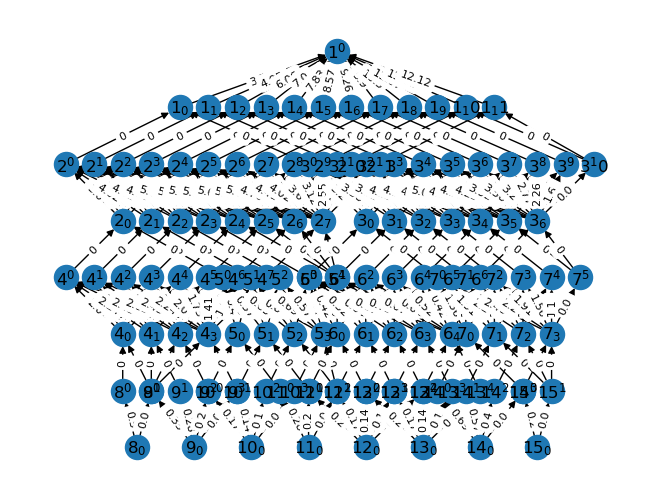

In [1777]:
extGraph, newPos = createExtendedGraph(bomGraph, bomGraphPos)
node_labels = {node: r'$' +node + '$' for node in extGraph.nodes()}
nx.draw(extGraph, newPos, labels = node_labels, with_labels=True)
edge_labels = {(u, v): round(data['cost'],2) 
              for u, v, data in extGraph.edges(data=True)}
nx.draw_networkx_edge_labels(extGraph, newPos, edge_labels=edge_labels, font_size=8)
plt.show()

## Show Shortest Paths

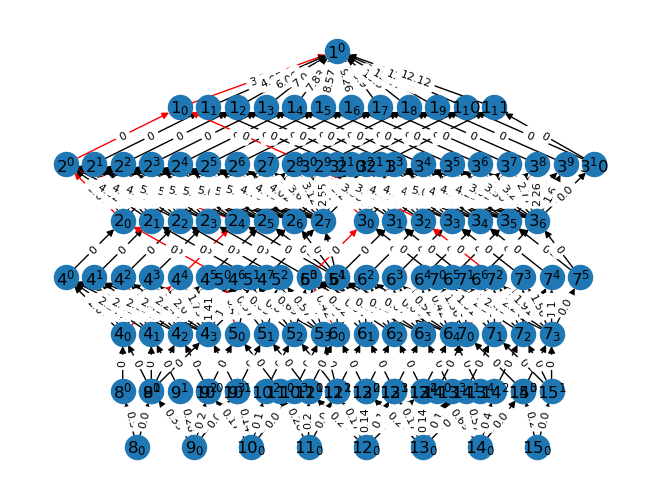

In [1778]:
edgesUsed = []
for n in ['4_0', '5_0', '6_0', '7_0']:
    shortest_path = nx.shortest_path(extGraph, n, '1^0', weight='cost')
    edges_in_path = list(zip(shortest_path[:-1], shortest_path[1:]))
    edgesUsed.extend(edges_in_path)
edgesUsedSet = set(edgesUsed)

edge_colors = ['red' if edge in edgesUsedSet else 'black' for edge in extGraph.edges()]

nx.draw(extGraph, newPos, labels = node_labels, edge_color=edge_colors, with_labels=True)
nx.draw_networkx_edge_labels(extGraph, newPos, edge_labels=edge_labels, font_size=8)
plt.show()

Note that two different 'net-time' edges are used for node 2, which is not allowed.

In [1779]:
def getLeafNodes(G):
    return [i for i in G.nodes() if G.nodes[i]['tier'] == numTiers]

numLeafNodes = len(getLeafNodes(bomGraph))

In [1780]:
def getNetFlowExpr(G, x, node):
    return qsum(x[e] for e in G.out_edges(node)) - qsum(x[e] for e in G.in_edges(node))

tier = nx.get_node_attributes(extGraph, 'tier')
inout = nx.get_node_attributes(extGraph, 'inout')

def getAllNetTimeEdges(G : nx.DiGraph):
    for e in G.edges:
        if G.edges[e]['type'] == 'net-time':
            yield e

def getAllNetTimeEdgeWithData(G : nx.DiGraph):
    for e in G.edges(data = True):
        if G.edges[e[0], e[1]]['type'] == 'net-time':
            yield e

def getAllNodeToNodeEdges(G : nx.DiGraph):
    for e in G.edges:
        if G.edges[e]['type'] == 'node-to-node':
            yield e

def getNetFlowExprRHS(n : int):
    if tier[n] == numTiers and inout[n] == 'in':
        return 1
    elif tier[n] == 0 and inout[n] == 'out':
        return -numLeafNodes
    else:
        return 0
    
def getNodeIDForNetTimeEdge(extGraph : nx.DiGraph, e : tuple):
    id = extGraph.nodes[e[0]]['id']
    return id

def getNumDescLeafNodesForNetTimeEdge(bomGraph : nx.DiGraph, 
                                      extGraph : nx.DiGraph, e : tuple):
    id = getNodeIDForNetTimeEdge(extGraph, e)
    return len(get_descendent_parts(bomGraph, id))

def getDescLeafNodesForNode(bomGraph : nx.DiGraph, extGraph : nx.DiGraph, 
                            node : str):
    id = extGraph.nodes[node]['id']
    return get_descendent_parts(bomGraph, id)

In [1781]:
def getOptimizedShortestPathModel(G : nx.DiGraph, vtypeY = GRB.BINARY, log = False):
    m = gp.Model("shortest_path")
    m.Params.LogToConsole = log

    #flowEdges = G.edges() - G.in_edges(finalNodeStr)
    #print("net time", list(getAllNetTimeEdges(G)))
    x = m.addVars(G.edges(), name="x")
    y = m.addVars(getAllNetTimeEdges(G), name="y", vtype=vtypeY)
    m._x = x
    m._y = y

    m.setObjective(qsum(x[e]*G.edges[e]['cost'] for e in getAllNodeToNodeEdges(G)) + 
                qsum(y[e]*G.edges[e]['cost'] for e in y), 
                GRB.MINIMIZE)

    m.addConstrs((x[e] <= getNumDescLeafNodesForNetTimeEdge(bomGraph, extGraph, e)*y[e] 
                                        for e in y), "UB")
    m.addConstrs((getNetFlowExpr(G, x, n) == getNetFlowExprRHS(n) 
                for n in G.nodes()), "netflow")

    m.optimize()
    handleGurobiStatus(m)
    m.write('shortest_path.lp')
    return m

m = getOptimizedShortestPathModel(extGraph, vtypeY = GRB.CONTINUOUS)
print("Relaxed Cost: $", format(m.ObjVal, ",.2f"))
edgesUsedRelaxed = list({(e[0], e[1]) for e in m._x if m._x[e].x > 0.0})
m = getOptimizedShortestPathModel(extGraph, log = False)
print("Optimal Cost: $", format(m.ObjVal, ",.2f"))
xVals = [m._x[e].x for e in m._x if m._x[e].x > 0.0]
edgesUsedOptimal = list({(e[0], e[1]) for e in m._x if m._x[e].x > 0.0})
costs = [extGraph.edges[e]['cost'] for e in edgesUsedOptimal]

df = pd.DataFrame({
    'Edge used': edgesUsedOptimal,
    'Holding cost': costs
})
df['Holding cost'] = df['Holding cost'].map('${:,.2f}'.format)
df

The model is optimal.
Relaxed Cost: $ 10.69
The model is optimal.
Optimal Cost: $ 11.55


,Edge used,Holding cost
0,"(14^3, 7_3)",$0.00
1,"(14_0, 14^3)",$0.00
2,"(1_9, 1^0)",$11.07
3,"(7_3, 7^5)",$0.00
4,"(9_0, 9^1)",$0.28
5,"(12_0, 12^3)",$0.10
6,"(15_0, 15^1)",$0.00
7,"(4^5, 2_5)",$0.00
8,"(15^1, 7_3)",$0.00
9,"(10_0, 10^3)",$0.00


## Edges Used: Relaxed  

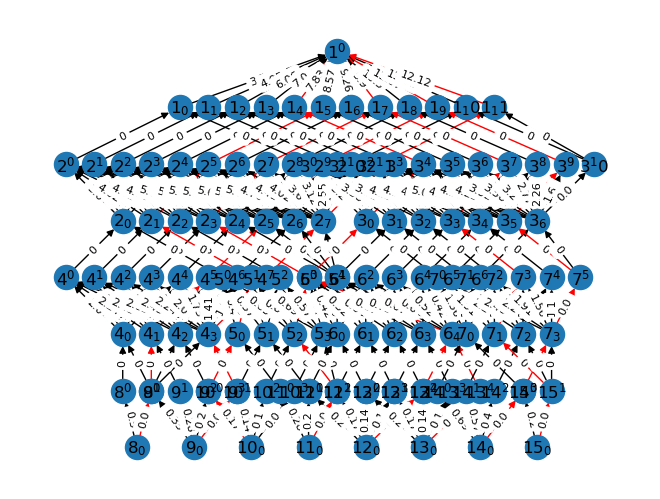

In [1782]:
edge_colors = ['red' if edge in edgesUsedRelaxed else 'black' for edge in extGraph.edges()]

nx.draw(extGraph, newPos, labels = node_labels, edge_color=edge_colors, with_labels=True)
nx.draw_networkx_edge_labels(extGraph, newPos, edge_labels=edge_labels, font_size=8)
plt.show()

## Edges Used: Optimal

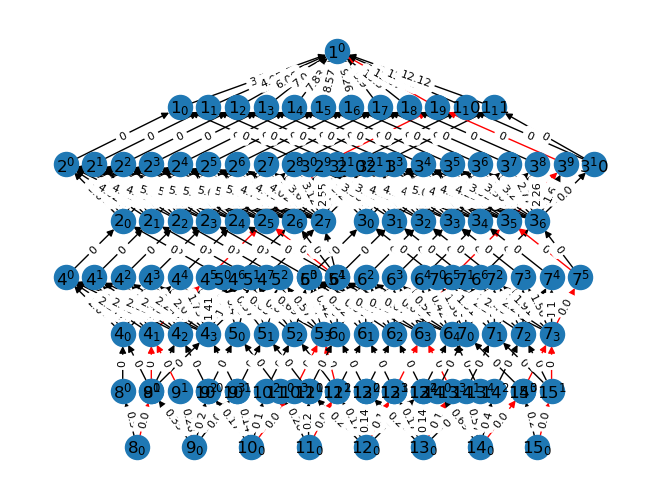

In [1783]:
edge_colors = ['red' if edge in edgesUsedOptimal else 'black' for edge in extGraph.edges()]

nx.draw(extGraph, newPos, labels = node_labels, edge_color=edge_colors, with_labels=True)
nx.draw_networkx_edge_labels(extGraph, newPos, edge_labels=edge_labels, font_size=8)
plt.show()

## Extended Multicommodity Graph

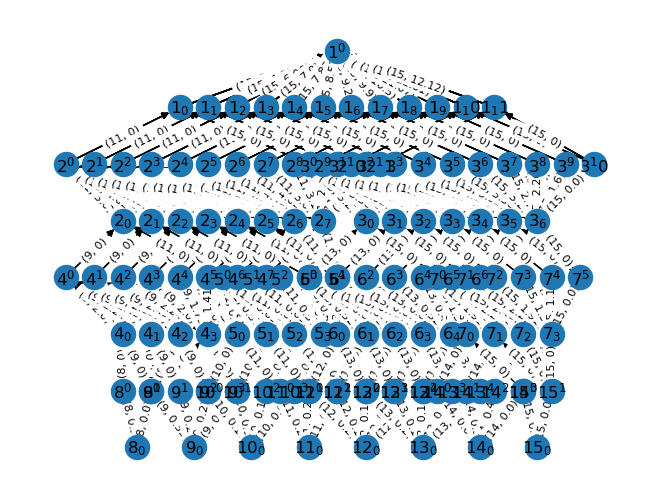

In [1784]:
def createExtendedMultiGraph(extGraph : nx.DiGraph):
    G = nx.MultiDiGraph()
    G.add_nodes_from(extGraph.nodes(data=True))
    for e in extGraph.edges(data = True):
        id = extGraph.nodes[e[0]]['id']
        for p in get_descendent_parts(bomGraph, id):
            attrDict = e[2]
            intime = attrDict['intime']
            outtime = attrDict['outtime']
            attrDict['part'] = p
            G.add_edge(e[0], e[1], **attrDict)
    return G

extMultiGraph = createExtendedMultiGraph(extGraph)

node_labels = {node: r'$' +node + '$' for node in extMultiGraph.nodes()}
nx.draw(extMultiGraph, newPos, labels = node_labels, with_labels=True)
edge_labels = {(u, v): (data['part'], round(data['cost'],2)) 
              for u, v, data in extMultiGraph.edges(data=True)}
nx.draw_networkx_edge_labels(extMultiGraph, newPos, edge_labels=edge_labels, font_size=8)
plt.show()

In [1785]:
# dp_G_multicommod = create_dp_graph(G, multi_commod = True)
# nodeTypes = nx.get_node_attributes(dp_G_multicommod, 'nodeType')
commodityEdges = [(e[0], e[1], e[2]['part']) for e in extMultiGraph.edges(data = True)]

def getCommodityInEdgesForNode(G, node):
    return [(e[0], e[1], e[2]['part']) for e in G.in_edges(node, data = True)]

# def getAllCommodityInEdges(G):
#     edgeList = []
#     for n in G.nodes():
#         if nodeTypes[n] == 'multi-component':
#             edgeList.extend(getCommodityInEdgesForNode(G, n))
#     return edgeList

# def getInEdgesForNode(G, node):
#     return {e for e in G.in_edges(node)}

# def getAllInEdges(G):
#     edgeList = []
#     for n in G.nodes():
#         if nodeTypes[n] == 'multi-component':
#             edgeList.extend(getInEdgesForNode(G, n))
#     return edgeList

def getCommodityOutEdges(G, node):
    return [(e[0], e[1], e[2]['part']) for e in G.out_edges(node, data = True)]

In [1786]:
def getNetFlowExpr(G, x, node):
    in_edges_sum = qsum(x[e] for e in getCommodityInEdgesForNode(G, node))
    out_edges_sum = qsum(x[e] for e in getCommodityOutEdges(G, node))
    return out_edges_sum - in_edges_sum

def getNetFlowExprWithPart(G, x, node, part):
    in_edges_sum = qsum(x[e] for e in getCommodityInEdgesForNode(G, node) 
                        if e[2] == part)
    out_edges_sum = qsum(x[e] for e in getCommodityOutEdges(G, node) 
                         if e[2] == part)
    return out_edges_sum - in_edges_sum

def getAllNetTimeEdgeCommodities(G : nx.DiGraph):
    for e in G.edges(data = True):
        if e[2]['type'] == 'net-time':
            yield (e[0], e[1], e[2]['part'])

def getAllNodeToNodeEdgeCommodities(G : nx.DiGraph):
    for e in G.edges(data = True):
        if e[2]['type'] == 'node-to-node':
            yield (e[0], e[1], e[2]['part'])

def getNetFlowExprRHS_multicommod(n : int):
    if tier[n] == numTiers and inout[n] == 'in':
        return 1
    elif tier[n] == 0 and inout[n] == 'out':
        return -1
    else:
        return 0

edgeCostCommodity = {(e[0], e[1], e[2]['part']) : e[2]['cost'] 
                for e in extMultiGraph.edges(data = True)}
    
edgeCostZ = {(e[0], e[1]) : e[2]['cost']
            for e in getAllNetTimeEdgeWithData(extGraph)}

def getOptimizedShortestPathModelMulticommodity(extGraph : nx.MultiDiGraph,
                                                extMultiGraph : nx.MultiDiGraph, 
                                                vtypeZ = GRB.BINARY, 
                                                log = False):
    m = gp.Model("shortest_paths")
    m.Params.LogToConsole = log

    #inEdges = getAllCommodityInEdges(G)
    #flowEdges = [item for item in commodityEdges if item not in inEdges]

    

    #print(extMultiGraph.edges)
    #print(list(getAllNetTimeEdges(extMultiGraph)))
    x = m.addVars(commodityEdges, name="x")
    #y = m.addVars(getAllNetTimeEdges(extMultiGraph), name="y")
    z = m.addVars(getAllNetTimeEdges(extGraph), name="z", vtype=vtypeZ)
    m._x = x
    #m._y = y
    m._z = z

    m.setObjective(qsum(edgeCostCommodity[e]*x[e] for e in getAllNodeToNodeEdgeCommodities(extGraph)) + 
                qsum(z[e]*edgeCostZ[e] for e in z), 
                GRB.MINIMIZE)

    #m.addConstrs((x[e] <= y[e] for e in y), "UB-y")
    m.addConstrs((x[e] <= z[e[0],e[1]] 
                  for e in getAllNetTimeEdgeCommodities(extMultiGraph)), 
                 "UB-z")
    #multiNodes = [n for n in extMultiGraph.nodes() if nodeTypes[n] == 'multi-component']
    #otherNodes = [n for n in extMultiGraph.nodes() if nodeTypes[n] == 'component']
    #m.addConstrs((getNetFlowExpr(extMultiGraph, x, n) == getNetFlowExprRHS(n) 
    #            for n in extMultiGraph.nodes() if ), "netflow")
    m.addConstrs((getNetFlowExprWithPart(extMultiGraph, x, n, p) == getNetFlowExprRHS_multicommod(n) 
                for n in extMultiGraph.nodes() 
                for p in getDescLeafNodesForNode(bomGraph, extGraph, n)), "netflow-multi")
    m.optimize()
    m.write("multicommodity.lp")
    handleGurobiStatus(m)
    return m

m = getOptimizedShortestPathModelMulticommodity(extGraph, extMultiGraph, 
                                                vtypeZ = GRB.CONTINUOUS, log = False)
print("Relaxed Cost: $", format(m.ObjVal, ",.2f"))
# for v in m.getVars():
#     if v.x > 0:
#         print('%s %g' % (v.varName, v.x))
edgesUsedRelaxedMulticommod = list({e for e in m._x if m._x[e].x > 0.0})
#print(edgesUsedRelaxedMulticommod)
costs = [edgeCostCommodity[e] for e in edgesUsedRelaxedMulticommod]

df = pd.DataFrame({
    'Edge used': edgesUsedRelaxedMulticommod,
    'Holding cost': costs
})
df['Holding cost'] = df['Holding cost'].map('${:,.2f}'.format)
print(df)

The model is optimal.
Relaxed Cost: $ 11.55
           Edge used Holding cost
0      (2^9, 1_9, 8)        $0.00
1     (6_3, 6^5, 13)        $0.00
2     (1_9, 1^0, 11)       $11.07
3    (15^1, 7_3, 15)        $0.00
4     (2^9, 1_9, 11)        $0.00
5      (2_5, 2^9, 9)        $0.00
6     (1_9, 1^0, 14)       $11.07
7     (5_3, 5^4, 11)        $0.00
8   (11_0, 11^2, 11)        $0.00
9     (5^4, 2_5, 11)        $0.00
10     (9_0, 9^1, 9)        $0.28
11   (12^3, 6_3, 12)        $0.00
12  (14_0, 14^3, 14)        $0.00
13    (3^9, 1_9, 13)        $0.00
14    (3_5, 3^9, 14)        $0.00
15    (6_3, 6^5, 12)        $0.00
16    (1_9, 1^0, 10)       $11.07
17    (6^5, 3_5, 12)        $0.00
18    (2^9, 1_9, 10)        $0.00
19     (2_5, 2^9, 8)        $0.00
20    (1_9, 1^0, 13)       $11.07
21    (3^9, 1_9, 12)        $0.00
22     (9^1, 4_1, 9)        $0.00
23    (2_5, 2^9, 11)        $0.00
24    (3^9, 1_9, 15)        $0.00
25    (5_3, 5^4, 10)        $0.00
26    (7^5, 3_5, 15)        $0.00
27  

In [1787]:
edgesUsedZ = list({e for e in m._z if m._z[e].x > 0.0})
costsZ = [edgeCostZ[e] for e in edgesUsedZ]
df = pd.DataFrame({
    'Edge used': edgesUsedZ,
    'Holding cost': costsZ
})
df['Holding cost'] = df['Holding cost'].map('${:,.2f}'.format)

print(df)

       Edge used Holding cost
0     (6_3, 6^5)        $0.00
1   (14_0, 14^3)        $0.00
2   (10_0, 10^3)        $0.00
3     (1_9, 1^0)       $11.07
4     (2_5, 2^9)        $0.00
5     (5_3, 5^4)        $0.00
6     (7_3, 7^5)        $0.00
7     (3_5, 3^9)        $0.00
8   (13_0, 13^3)        $0.10
9     (9_0, 9^1)        $0.28
10    (4_1, 4^5)        $0.00
11  (11_0, 11^2)        $0.00
12  (12_0, 12^3)        $0.10
13  (15_0, 15^1)        $0.00
14    (8_0, 8^1)        $0.00


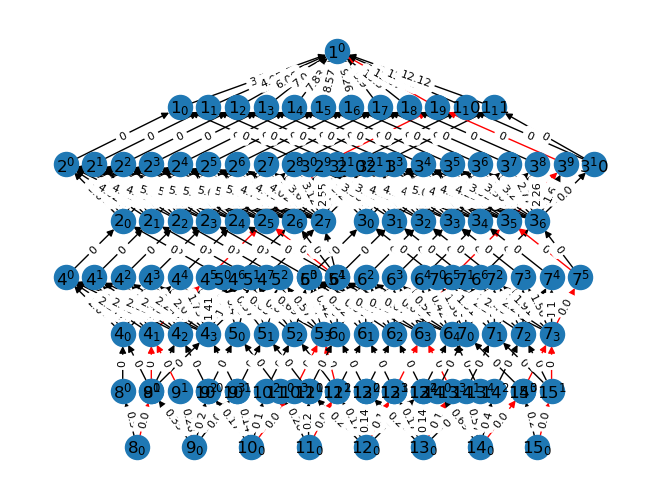

In [1788]:
edgesUsedRelaxedMulticommodNoCommod = [(e[0], e[1]) for e in edgesUsedRelaxedMulticommod]
edge_colors = ['red' if edge in edgesUsedRelaxedMulticommodNoCommod else 'black' for edge in extGraph.edges()]
edge_labels = {(u, v): round(data['cost'],2) 
              for u, v, data in extMultiGraph.edges(data=True)}
nx.draw(extGraph, newPos, labels = node_labels, edge_color=edge_colors, with_labels=True)
nx.draw_networkx_edge_labels(extGraph, newPos, edge_labels=edge_labels, font_size=8)
plt.show()

In [1789]:
m = getOptimizedShortestPathModelMulticommodity(extGraph, extMultiGraph,log = False)
print("Optimal Cost: $", format(m.ObjVal, ",.2f"))

The model is optimal.
Optimal Cost: $ 11.55


In [1790]:
# edgesUsed_multicommod = [e for e in m._x if m._x[e].x > 0.0]

In [1791]:
# xVals = [m._x[e].x for e in m._x if m._x[e].x > 0.0]
# edgesUsed = list({(e[0], e[1]) for e in m._x if m._x[e].x > 0.0})

# costs = [dp_G.edges[e]['cost'] for e in edgesUsed]

# df = pd.DataFrame({
#     'Edge used': edgesUsed,
#     'Holding cost': costs
# })
# df['Holding cost'] = df['Holding cost'].map('${:,.2f}'.format)
# print("Cost: $", format(m.ObjVal, ",.2f"))
# df

In [1792]:
# edgesUsed = [(e[0], e[1]) for e in m._x if m._x[e].x > 0.0]
# edge_colors = ['red' if edge in edgesUsed else 'black' 
#                for edge in dp_G.edges()]
# nx.draw(dp_G, pos, edge_color=edge_colors, 
#         labels = node_labels, with_labels=True)
# nx.draw_networkx_edge_labels(dp_G, pos, edge_labels=edge_labels, 
#                              font_size=8)
# plt.show()

## Solution: Inventory Held

In [1793]:
# node_labels = {}
# for n in bomGraph.nodes():
#     for sIn in get_sIn_range_for_g_fn(n):
#             for sOut in get_sOut_range_for_g_fn_forIn(n, sIn):
#                 nodeTupleIn = getNodeString(n, sIn, False)
#                 nodeTupleOut = getNodeString(n, sOut, True)
#                 if (nodeTupleIn, nodeTupleOut) in edgesUsed:
#                     netTime = sIn + processTimesDict[n] - sOut
#                     node_labels[n] = '{} ({})'.format(n, netTime)

In [1794]:
# pos = nx.spring_layout(G)
# nx.draw(bomGraph, pos, labels = node_labels, with_labels=True, node_size=2000)
# plt.show()